# Project : Bayesian Inverse Reinforcement Learning

### Importing required libraries

In [17]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from collections import defaultdict
import random

The ACTION_TO_INDEX dictionary provides an index for a particular action in our Markov Decision Process environment. This mapping helps a lot in the representation and handling of actions in our algorithms.

Here is how actions are represented:

'L' (Left): 0
'R' (Right): 1
'U' (Up): 2
'D' (Down): 3

This is because our dictionary is invoked in many functions and methods of our code so that actions can easily be identified properly by their index to enhance the clarity and efficiency of our computational procedures.

In [10]:
ACTION_TO_INDEX = {'L': 0, 'R': 1, 'U': 2, 'D': 3}

The following class (`PartialMDP`) simulates a grid-based MDP environment

In [14]:
class PartialMDP:
    def __init__(self, rows=8, columns=8, slip_probability=0.2, gamma=0.9):
        """
        Initializes a partially defined Markov Decision Process.
        
        Parameters:
        states (list): List of all possible states.
        actions (dict): Dictionary where keys are states and values are lists of possible actions from that state.
        transition_probabilities (dict): Nested dictionary where keys are (state, action) tuples and values are
                                         lists of (probability, next_state) tuples.
        gamma (float): Discount factor for future rewards.
        """
        self.rows = rows
        self.columns = columns
        self.slip_probability = slip_probability
        self.gamma = gamma
        self.states = [(i, j) for i in range(0, rows) for j in range(0, columns)]
        self.actions = ['L', 'R', 'U', 'D']
        self.transitions = self.initialize_transitions()
        self.grid_visual = np.zeros((rows, columns))
        self.rewards = np.zeros((rows, columns))
        self.setup_features()
        self.value_function = {state: 0.0 for state in self.states}
        self.policy = {state: 'R' for state in self.states} # Here we set initial policy to 'Right' for all states

    def initialize_transitions(self):
        transitions = {}
        for state in self.states:
            transitions[state] = {}
            for action in self.find_actions(state):
                transitions[state][action] = self.calculate_transitions(state, action)
        return transitions
    
    def find_actions(self, state):
        x, y = state
        if (x, y) == (0, 0):
            return ['D', 'R']
        elif (x, y) == (self.rows - 1, self.columns - 1):
            return ['U', 'L']
        elif (x, y) == (0, self.columns - 1):
            return ['L', 'D']
        elif (x, y) == (self.rows - 1, 0):
            return ['R', 'U']
        elif x == 0:
            return ['D', 'L', 'R']
        elif x == self.rows - 1:
            return ['U', 'L', 'R']
        elif y == 0:
            return ['U', 'D', 'R']
        elif y == self.columns - 1:
            return ['U', 'D', 'L']
        else:
            return self.actions

    def calculate_transitions(self, state, action):
        x, y = state
        next_state = self.move(x, y, action)
        transitions = []
        if next_state != state:
            slip_states = [self.move(x, y, a) for a in self.get_perpendicular_actions(action)]
            transitions = [(self.slip_probability / 2, slip) for slip in slip_states]
            transitions.append((1 - self.slip_probability, next_state))
        else:
            transitions = [(1, next_state)]
        return transitions
    
    def move(self, x, y, action):
        if action == 'L' and y > 0:
            return (x, y - 1)
        elif action == 'R' and y < self.columns - 1:
            return (x, y + 1)
        elif action == 'U' and x > 0:
            return (x - 1, y)
        elif action == 'D' and x < self.rows - 1:
            return (x + 1, y)
        return (x, y)

    def get_perpendicular_actions(self, action):
        return ['U', 'D'] if action in ['L', 'R'] else ['L', 'R']
    
    def setup_features(self):
        # Defining a random of a gridworld with some features
        treasure_location = [(7, 0)]
        bomb_locations = [(1, 3), (2, 6), (5, 2)]
        mud_locations = [(0, 2), (0, 5), (1, 5), (6, 2), (7, 2), (7, 5), (6, 5), (1, 2)]
        water_locations = [(row, col) for row in range(1, 3) for col in range(0, 3)]
        mountain_locations = [(row, col) for row in range(4, 6) for col in range(2, 5)]

        # Setting rewards and transition probabilities for special features
        for state in self.states:
            x, y = state[0], state[1]
            if state in mud_locations:
                self.rewards[x][y] = -2
            elif state in water_locations:
                self.rewards[x][y] = -1
            elif state in mountain_locations:
                self.rewards[x][y] = -1.5
            elif state in bomb_locations:
                self.rewards[x][y] = -100
            elif state == treasure_location:
                self.rewards[x][y] = 100

    def show_environment(self):
        # Visual representation for debugging
        env_visual = np.zeros((self.rows, self.columns))
        mud_locations = [(0, 2), (0, 5), (1, 5), (6, 2), (7, 2), (7, 5), (6, 5), (1, 2)]
        water_locations = [(row, col) for row in range(1, 3) for col in range(0, 3)]
        mountain_locations = [(row, col) for row in range(4, 6) for col in range(2, 5)]
        bomb_locations = [(1, 3), (2, 6), (5, 2)]
        treasure_location = [(7, 0)]
        for x, y in mud_locations:
            env_visual[x][y] = 0.5  
        for x, y in water_locations:
            env_visual[x][y] = 0.75 
        for x, y in mountain_locations:
            env_visual[x][y] = 1  
        for x, y in bomb_locations:
            env_visual[x][y] = -1 
        env_visual[treasure_location[0]] = 2  

        cmap = ListedColormap(sns.color_palette("coolwarm", n_colors=10).as_hex())

        plt.figure(figsize=(10, 8))
        sns.heatmap(env_visual, cmap=cmap, annot=True, cbar=False,
                    linewidths=.5, square=True, fmt="",
                    xticklabels=list(range(1, 9)),
                    yticklabels=[chr(i) for i in range(ord('A'), ord('H') + 1)])
        ax = plt.gca()
        plt.title('GridWorld MDP State Visualization')

        plt.show()

### Gridworld instantiation

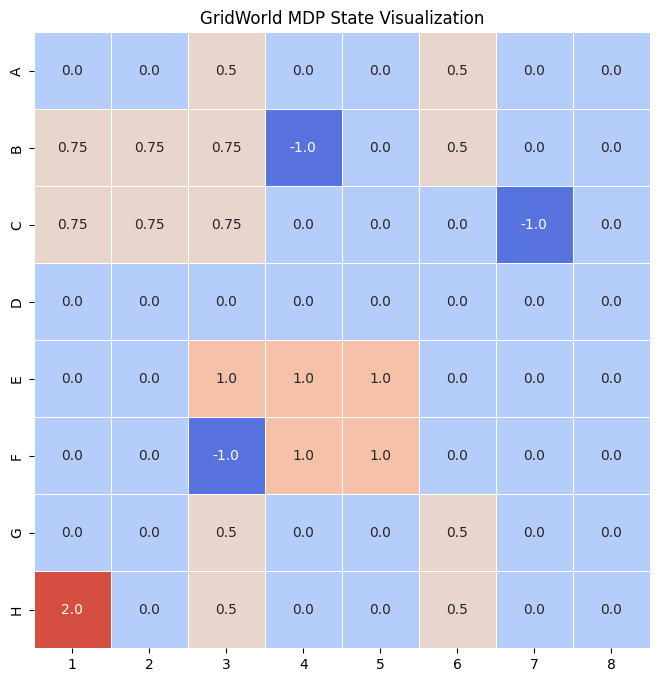

In [15]:
# Instantiate the gridworld MDP
gridworld = PartialMDP()
gridworld.show_environment()

### Transition probabilities calculation

In [16]:
state = (3, 3)
action = 'R'

transitions = gridworld.calculate_transitions(state, action)

print("Transitions for state", state, "and action", action, ":")
for prob, next_state in transitions:
    print("Probability:", prob, "-> Next State:", next_state)

Transitions for state (3, 3) and action R :
Probability: 0.1 -> Next State: (2, 3)
Probability: 0.1 -> Next State: (4, 3)
Probability: 0.8 -> Next State: (3, 4)


## Partial MDP generalisation

The following code defines a class `RandomPartialMDP` that simulates a grid-based MDP environment with randomly assigned features. 

#### GridWorld generalization

In [18]:
class RandomPartialMDP:
    def __init__(self, rows=8, columns=8, slip_probability=0.2, gamma=0.9, feature_counts=None):
        self.rows = rows
        self.columns = columns
        self.slip_probability = slip_probability
        self.gamma = gamma
        self.states = [(i, j) for i in range(rows) for j in range(columns)]
        self.actions = ['L', 'R', 'U', 'D']
        self.transitions = self.initialize_transitions()
        self.grid_visual = np.zeros((self.rows, self.columns))
        if feature_counts is None:
            feature_counts = {}
        self.grid_features = self.randomize_features(feature_counts)
        self.rewards = self.get_rewards()

    def initialize_transitions(self):
        transitions = {}
        for state in self.states:
            transitions[state] = {}
            for action in self.actions:
                transitions[state][action] = self.calculate_transitions(state, action)
        return transitions

    def calculate_transitions(self, state, action):
        x, y = state
        next_state = self.move(x, y, action)
        transitions = []
        if next_state != state:
            slip_states = [self.move(x, y, a) for a in self.get_perpendicular_actions(action)]
            transitions = [(self.slip_probability / 2, slip) for slip in slip_states]
            transitions.append((1 - self.slip_probability, next_state))
        else:
            transitions = [(1, next_state)]
        return transitions

    def move(self, x, y, action):
        if action == 'L' and y > 0:
            return (x, y - 1)
        elif action == 'R' and y < self.columns - 1:
            return (x, y + 1)
        elif action == 'U' and x > 0:
            return (x - 1, y)
        elif action == 'D' and x < self.rows - 1:
            return (x + 1, y)
        return (x, y)

    def get_perpendicular_actions(self, action):
        return ['U', 'D'] if action in ['L', 'R'] else ['L', 'R']

    def randomize_features(self, feature_counts):
        features = ['Treasure', 'Bomb', 'Mud', 'Water', 'Mountain']
        grid_features = defaultdict(list)
        available_states = list(self.states)

        for feature, count in feature_counts.items():
            if count > len(available_states):
                raise ValueError(f"Not enough available states to place {count} {feature}(s)")
            chosen_states = random.sample(available_states, count)
            for state in chosen_states:
                grid_features[state].append(feature)
                available_states.remove(state)

        return grid_features

    def get_rewards(self):
        # Assume the initial rewards are set to some default value, e.g., zeros
        rewards = np.zeros((self.rows, self.columns))

        # Update rewards based on features
        for (x, y), features in self.grid_features.items():
            for feature in features:
                if feature == 'Mud':
                    rewards[x, y] -= 0.5
                elif feature == 'Water':
                    rewards[x, y] -= 0.75
                elif feature == 'Mountain':
                    rewards[x, y] -= 1
                elif feature == 'Bomb':
                    rewards[x, y] -= 10
                elif feature == 'Treasure':
                    rewards[x, y] += 20
        return rewards

    def show_environment(self):

        env_visual = np.zeros((self.rows, self.columns))
        cmap = ListedColormap(sns.color_palette("coolwarm", n_colors=10).as_hex())
        plt.figure(figsize=(10, 8))

        for state, features in self.grid_features.items():
            for feature in features:
                if feature == 'Mud':
                    env_visual[state[0]][state[1]] = 0.5
                elif feature == 'Water':
                    env_visual[state[0]][state[1]] = 0.75
                elif feature == 'Mountain':
                    env_visual[state[0]][state[1]] = 1
                elif feature == 'Bomb':
                    env_visual[state[0]][state[1]] = -1
                elif feature == 'Treasure':
                    env_visual[state[0]][state[1]] = 2

        sns.heatmap(env_visual, cmap=cmap, annot=True, cbar=False,
                    linewidths=.5, square=True, fmt="",
                    xticklabels=list(range(1, self.columns + 1)),
                    yticklabels=[chr(i) for i in range(ord('A'), ord('A') + self.rows)])
        plt.title('Randomly Generated MDP State Visualization')
        plt.show()

#### Test

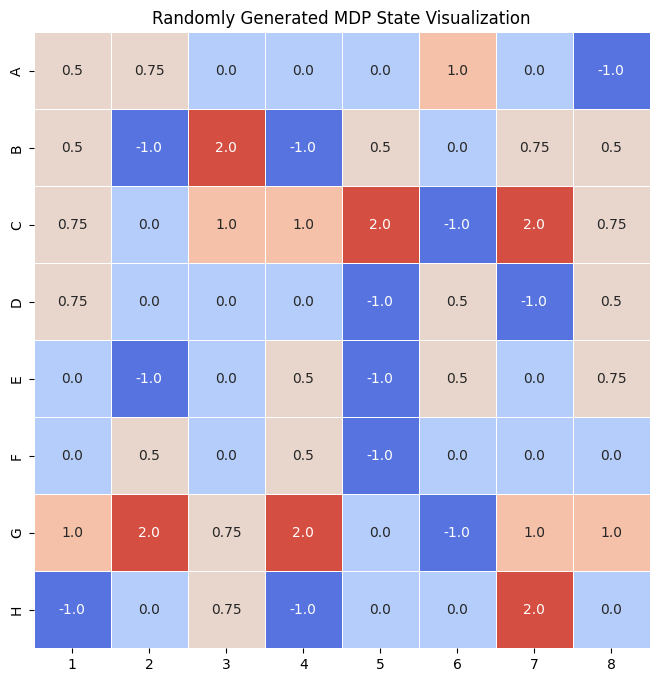

In [19]:
feature_counts = {'Treasure': 6, 'Bomb': 12, 'Mud': 10, 'Water': 8, 'Mountain': 6}
random_mdp = RandomPartialMDP(feature_counts=feature_counts)
random_mdp.show_environment()

With our gridworld environment now established and modeled as a Markov Decision Process (MDP), we can proceed to explore algorithms designed to solve MDPs. In this context, we will focus specifically on the Policy Iteration algorithm.

We'll create a class for this algorithm with these 3 methods: \
    - **Evaluation** with evaluate method \
    - **Iteration** with iterate method \
    - **Improvement** with impove method

In [20]:
class PolicyIteration:
    def __init__(self, mdp, reward_function, tolerance=1e-6, max_iter=1000):
        self.mdp = mdp
        self.reward_function = reward_function
        self.tolerance = tolerance
        self.max_iter = max_iter
        # Set initial policy to 'Right' ('R') for all states
        self.policy = {state: 'R' for state in mdp.states}

    def evaluate_policy(self):
        #inistailiser le
        V = {state: 0 for state in self.mdp.states}

        for _ in range(self.max_iter):
            delta = 0
            for state in self.mdp.states:
                v = V[state]
                action = self.policy[state]
                next_states = self.mdp.transitions[state][action]
                reward = self.mdp.rewards[state[0], state[1]]  # Fetch dynamic reward
                expected_value = sum(prob * (self.reward_function[state] + self.mdp.gamma * V[next_state]) for prob, next_state in next_states)
                V[state] = expected_value
                delta = max(delta, abs(v - V[state]))
            if delta < self.tolerance:
                break

        return V

    def improve_policy(self, V):
        stable = True
        for state in self.mdp.states:
            old_action = self.policy[state]
            best_action = None
            best_value = float('-inf')
            for action in self.mdp.actions:
                action_idx = ACTION_TO_INDEX[action]
                next_states = self.mdp.transitions[state][action]
                value = sum(prob * (self.reward_function[state] + self.mdp.gamma * V[next_state]) for prob, next_state in next_states)
                if value > best_value:
                    best_value = value
                    best_action = action
            self.policy[state] = best_action
            if old_action != best_action:
                stable = False
        return stable

    def solve(self):
        for _ in range(self.max_iter):
            V = self.evaluate_policy()
            stable = self.improve_policy(V)
            if stable:
                break
        return V, self.policy


### Testing the algorithm

In [21]:
reward_function = random_mdp.rewards
policy_iteration = PolicyIteration(random_mdp, reward_function)
optimal_values, optimal_policy = policy_iteration.solve()
print("Optimal Values:")
print(optimal_values)
print("\nOptimal Policy:")
print(optimal_policy)

Optimal Values:
{(0, 0): 52.791352793204986, (0, 1): 60.649323109365056, (0, 2): 70.14923582481399, (0, 3): 61.61658625233839, (0, 4): 68.63774451405185, (0, 5): 68.6269828107303, (0, 6): 76.647487587584, (0, 7): 61.08955528109227, (1, 0): 54.14020993110242, (1, 1): 60.37149662536076, (1, 2): 82.14625610831823, (1, 3): 61.818264243398325, (1, 4): 79.04975547737865, (1, 5): 78.54348970711848, (1, 6): 90.24027753993252, (1, 7): 81.51836394844642, (2, 0): 61.57521815630503, (2, 1): 64.0861510470107, (2, 2): 71.04052507491883, (2, 3): 79.19407949628874, (2, 4): 92.94055319059575, (2, 5): 82.15624558155895, (2, 6): 106.36765471545306, (2, 7): 92.44456505013505, (3, 0): 70.85513290270215, (3, 1): 72.43157612872288, (3, 2): 79.95401340169221, (3, 3): 85.70264551861507, (3, 4): 74.15087851041665, (3, 5): 94.47356452401824, (3, 6): 98.1299756377587, (3, 7): 103.03556638588988, (4, 0): 81.54073591169916, (4, 1): 81.74826896345544, (4, 2): 91.28046411004678, (4, 3): 99.76834161198603, (4, 4): 86.

## Imperfect tutor simulator

The following class `ImperfectTutorSimulation` describes a tutor that simulates an agent following a policy in an MDP with some probability of taking suboptimal actions. 

In [22]:
class ImperfectTutorSimulation:
    def __init__(self, mdp, reward_function, policy, optimal_action_prob=0.95):
        self.mdp = mdp
        self.reward_function = reward_function
        self.policy = policy
        self.optimal_action_prob = optimal_action_prob

    def simulate(self, s0, M):
        state_action_pairs = []
        current_state = s0

        for _ in range(M):
            if random.random() < self.optimal_action_prob:
                action = self.policy[current_state]
            else:
                action = random.choice(self.mdp.actions)

            state_action_pairs.append((current_state, action))

            # how to get the next state based on chosen action
            next_states = self.mdp.transitions[current_state][action]
            probabilities, states = zip(*next_states)
            next_state = random.choices(states, probabilities)[0]

            current_state = next_state

        return state_action_pairs

    def generate_observations(mdp, policy, initial_state, num_steps):
        simulator = ImperfectTutorSimulation(mdp, policy, optimal_action_prob=0.95)
        return simulator.simulate(initial_state, num_steps)

#### Testing the tutor

In [23]:
imperfect_tutor = ImperfectTutorSimulation(random_mdp, reward_function, optimal_policy)
initial_state = (0, 0)
num_timesteps = 10
state_action_pairs = imperfect_tutor.simulate(initial_state, num_timesteps)

print("Generated State-Action Pairs:")
print(state_action_pairs)

Generated State-Action Pairs:
[((0, 0), 'R'), ((1, 0), 'D'), ((2, 0), 'D'), ((2, 0), 'D'), ((3, 0), 'D'), ((3, 0), 'D'), ((4, 0), 'D'), ((5, 0), 'R'), ((5, 1), 'D'), ((6, 1), 'R')]


Now, we are going to work step by step for the **Bayesian framework**. We will first try to define some classes representing priors (Spoiler Alert: we won't use all the priors :)) then we will iteratively calculate the **Q-values** for all state-action pairs in the MDP using a method similar to value iteration, considering the rewards and the probability of transitioning to other states.

In [24]:
class UniformPrior:
    def __init__(self, R_max):
        self.R_max = R_max

    def prior(self, R):
        return 1 if np.max(np.abs(R)) <= self.R_max else 0

class GaussianPrior:
    def __init__(self, sigma):
        self.sigma = sigma

    def prior(self, R):
        return np.exp(-np.sum(R**2) / (2 * self.sigma**2))

class BetaPrior:
    def __init__(self, R_max):
        self.R_max = R_max

    def prior(self, R):
        R_normalized = R / self.R_max
        return np.prod(R_normalized**0.5 * (1 - R_normalized)**0.5)


In [25]:
class QValueCalculator:
    def __init__(self, mdp):
        self.mdp = mdp

    def calculate_q_values(self, R):
        Q = np.zeros((self.mdp.rows, self.mdp.columns, len(self.mdp.actions)))
        for _ in range(100):
            for state in self.mdp.states:
                x, y = state
                for action_idx, action in enumerate(self.mdp.actions):
                    action_idx = ACTION_TO_INDEX[action]
                    transitions = self.mdp.transitions[state][action]
                    Q[x, y, action_idx] = R[x, y] + self.mdp.gamma * sum(prob * Q[next_x, next_y].max() for prob, (next_x, next_y) in transitions)
        return Q


In [26]:
class LikelihoodCalculator:
    def __init__(self, mdp, alpha):
        self.mdp = mdp
        self.alpha = alpha

    def likelihood(self, Q, observations):
        likelihood = 1.0
        for state, action in observations:
            x, y = state
            action_idx = self.mdp.actions.index(action)
            exp_q = np.exp(self.alpha * Q[x, y])
            likelihood *= np.exp(self.alpha * Q[x, y, action_idx]) / np.sum(exp_q)
        return likelihood


In [28]:
class PosteriorCalculator:
    def __init__(self, prior, q_calculator, likelihood_calculator):
        self.prior = prior
        self.q_calculator = q_calculator
        self.likelihood_calculator = likelihood_calculator

    def posterior(self, R, observations):
        Q = self.q_calculator.calculate_q_values(R)
        likelihood = self.likelihood_calculator.likelihood(Q, observations)
        return self.prior.prior(R) * likelihood


In [27]:
class RatioCalculator:
    def __init__(self, posterior_calculator):
        self.posterior_calculator = posterior_calculator

    def compute_ratio(self, R1, R2, observations):
        posterior_R1 = self.posterior_calculator.posterior(R1, observations)
        posterior_R2 = self.posterior_calculator.posterior(R2, observations)
        return posterior_R1 / posterior_R2


Instantiating all the classes created

In [30]:
uniform_prior = UniformPrior(R_max=1)
gaussian_prior = GaussianPrior(sigma=1)
beta_prior = BetaPrior(R_max=1)

q_calculator = QValueCalculator(random_mdp)
likelihood_calculator = LikelihoodCalculator(random_mdp, alpha=1)

posterior_calculator = PosteriorCalculator(gaussian_prior, q_calculator, likelihood_calculator)
ratio_calculator = RatioCalculator(posterior_calculator)

R1 = np.random.rand(random_mdp.rows, random_mdp.columns)
R2 = np.random.rand(random_mdp.rows, random_mdp.columns) 
observations = [((0, 0), 'R'), ((1, 0), 'D')]
ratio = ratio_calculator.compute_ratio(R1, R2, observations)
print(f"Ratio of P(R1|O) / P(R2|O): {ratio}")

Ratio of P(R1|O) / P(R2|O): 0.6510697496260427


## Policy Walk

In this section, we're going to explore the **Policy Walk** algorithm. This method helps us improve the reward function of a MDP step by step to find the best possible policy. The idea behind PolicyWalk is to tweak the reward function slightly and then see how those changes affect the policies that come out of it.

This approach is especially handy for complex MDPs where the reward function isn't clearly defined or is tricky to figure out. By experimenting with small adjustments, we can gradually discover a reward structure that works well, even if we don't have a perfect definition of rewards at the start.

The following class `PolicyWalk` performs a policy walk to find an optimal reward function for an MDP.

In [31]:
class PolicyWalk:
    def __init__(self, mdp, prior, posterior_calculator, observations, step_size=0.1, iterations=5):
        self.mdp = mdp
        self.prior = prior
        self.posterior_calculator = posterior_calculator
        self.observations = observations
        self.step_size = step_size
        self.iterations = iterations

    def walk(self):
        R = self.random_reward_vector()
        pi = self.policy_iteration(R)
        best_R = R
        best_posterior = self.posterior_calculator.posterior(R, observations)

        for _ in range(self.iterations):
            R_prime = self.neighbor_reward_vector(R)
            Q_prime = self.calculate_Q_values(R_prime)

            if self.is_policy_improvement(Q_prime, pi):
                pi_prime = self.policy_iteration(R_prime, pi)
                accept_prob = min(1, self.posterior_calculator.posterior(R_prime, observations) / self.posterior_calculator.posterior(R, observations))

                if np.random.rand() < accept_prob:
                    R, pi = R_prime, pi_prime

            else:
                accept_prob = min(1, self.posterior_calculator.posterior(R_prime, observations) / self.posterior_calculator.posterior(R, observations))

                if np.random.rand() < accept_prob:
                    R = R_prime

            current_posterior = self.posterior_calculator.posterior(R, observations)

            if current_posterior > best_posterior:
                best_R, best_posterior = R, current_posterior

        return best_R


    def random_reward_vector(self):
        np.random.seed(42)
        return np.random.uniform(-1, 1, size=(self.mdp.rows, self.mdp.columns))


    def neighbor_reward_vector(self, R):
        R_prime = R.copy()
        i,j = np.random.randint(0, R.shape[0]), np.random.randint(0, R.shape[1])
        R_prime[i, j] += np.random.choice([-self.step_size, self.step_size])
        return np.clip(R_prime, -1, 1)


    def calculate_Q_values(self, R):
        q_calculator = QValueCalculator(self.mdp)
        return q_calculator.calculate_q_values(R)


    def is_policy_improvement(self, Q, pi):
        for (x,y) in self.mdp.states:
            try:
                pi_action = pi[x, y]
                pi_action_index = ACTION_TO_INDEX[pi_action]  # Convert label to index
                max_q_value = max(Q[x, y, a_idx] for a_idx in range(len(self.mdp.actions)))
                pi_q_value = Q[x, y, pi_action_index]
                if max_q_value > pi_q_value:
                    return True
            except IndexError as e:
                print(f"IndexError: pi[{x},{y}] = {pi[x,y]} with Q shape {Q.shape}")
                raise e
        return False


    def policy_iteration(self, R, pi=None):
        policy_iter = PolicyIteration(self.mdp, R)
        _, policy = policy_iter.solve()
        return policy

Instantiating the policy walk

In [32]:
posterior_calculator = PosteriorCalculator(gaussian_prior, q_calculator, likelihood_calculator)
policy_walk = PolicyWalk(random_mdp, None, posterior_calculator, 0.1, 1000)
best_reward = policy_walk.walk()
print("Best reward function found:", best_reward)

Best reward function found: [[-0.25091976  0.90142861  0.46398788  0.19731697 -0.68796272 -0.68801096
  -0.88383278  0.73235229]
 [ 0.20223002  0.41614516 -0.95883101  0.9398197   0.66488528 -0.57532178
  -0.63635007 -0.63319098]
 [-0.39151551  0.04951286 -0.13610996 -0.41754172  0.22370579 -0.72101228
  -0.4157107  -0.26727631]
 [-0.08786003  0.57035192 -0.60065244  0.02846888  0.18482914 -0.90709917
   0.2150897  -0.65895175]
 [-0.86989681  0.89777107  0.93126407  0.6167947  -0.39077246 -0.80465577
   0.36846605 -0.11969501]
 [-0.75592353 -0.00964618 -0.93122296  0.8186408  -0.48244004  0.32504457
  -0.37657785  0.04013604]
 [ 0.09342056 -0.63029109  0.93916926  0.55026565  0.87899788  0.7896547
   0.19579996  0.84374847]
 [-0.823015   -0.60803428 -0.90954542 -0.34933934 -0.22264542 -0.45730194
   0.65747502 -0.28649335]]


Interpreting some best rewards values:
Each value in this row corresponds to a specific state in the first row of the grid-based MDP environment. Here's a detailed interpretation:

* State (0, 0): Reward = -0.25091976
This state has a slightly negative reward, indicating a slightly undesirable state for the agent.

* State (0, 1): Reward = 0.90142861
This state has a high positive reward, making it a highly desirable state for the agent to reach.

* State (0, 2): Reward = 0.46398788
This state has a positive reward, though not as high as state (0, 1), indicating it is still desirable but to a lesser extent.

* State (0, 3): Reward = 0.19731697
This state has a moderate positive reward, making it somewhat desirable.

* State (0, 4): Reward = -0.68796272
This state has a significantly negative reward, indicating it is highly undesirable for the agent to visit.

* State (0, 5): Reward = -0.68801096
Similar to state (0, 4), this state also has a significantly negative reward, making it undesirable.

* State (0, 6): Reward = -0.88383278
This state has a very negative reward, strongly discouraging the agent from visiting it.

* State (0, 7): Reward = 0.73235229
This state has a high positive reward, making it a desirable state for the agent to aim for.

### Advanced version of policy walk

The following class `CoolingPolicyWalk` performs a policy walk but with simulated annealing to find an optimal reward function for an MDP.

In [33]:
class CoolingPolicyWalk:
    def __init__(self, mdp, prior, posterior_calculator, observations, step_size=0.1, iterations=5, initial_temp=1.0, cooling_rate=0.95):
        self.mdp = mdp
        self.prior = prior
        self.posterior_calculator = posterior_calculator
        self.observations = observations
        self.step_size = step_size
        self.iterations = iterations
        self.temperature = initial_temp
        self.cooling_rate = cooling_rate

    def walk(self):
        R = self.random_reward_vector()
        pi = self.policy_iteration(R)
        best_R = R
        best_posterior = self.posterior_calculator.posterior(R, self.observations)

        for i in range(self.iterations):
            T = self.temperature * (self.cooling_rate ** i)  # Decaying temperature
            if i % 5 == 0 or i == self.iterations - 1:
                R_prime = self.neighbor_reward_vector(R)
                Q_prime = self.calculate_Q_values(R_prime)

                if self.is_policy_improvement(Q_prime, pi):
                    pi_prime = self.policy_iteration(R_prime, pi)
                    delta_posterior = np.log(self.posterior_calculator.posterior(R_prime, self.observations)) - np.log(self.posterior_calculator.posterior(R, self.observations))
                    accept_prob = min(1, np.exp(delta_posterior / T))

                    if np.random.rand() < accept_prob:
                        R, pi = R_prime, pi_prime

                else:
                    delta_posterior = np.log(self.posterior_calculator.posterior(R_prime, self.observations)) - np.log(self.posterior_calculator.posterior(R, self.observations))
                    accept_prob = min(1, np.exp(delta_posterior / T))

                    if np.random.rand() < accept_prob:
                        R = R_prime

                current_posterior = self.posterior_calculator.posterior(R, self.observations)
                if current_posterior > best_posterior:
                    best_R, best_posterior = R, current_posterior

            return best_R


    def random_reward_vector(self):
        np.random.seed(42)  # Optional: Seed for reproducibility
        return np.random.uniform(-1, 1, size=(self.mdp.rows, self.mdp.columns))

    def neighbor_reward_vector(self, R):
        R_prime = R.copy()
        i, j = np.random.randint(0, R.shape[0]), np.random.randint(0, R.shape[1])
        R_prime[i, j] += np.random.choice([-self.step_size, self.step_size])
        return np.clip(R_prime, -1, 1)

    def calculate_Q_values(self, R):
        q_calculator = QValueCalculator(self.mdp)
        return q_calculator.calculate_q_values(R)

    def is_policy_improvement(self, Q, pi):
        for (x, y) in self.mdp.states:
            try:
                pi_action = pi[x, y]
                pi_action_index = ACTION_TO_INDEX[pi_action]
                max_q_value = max(Q[x, y, a_idx] for a_idx in range(len(self.mdp.actions)))
                pi_q_value = Q[x, y, pi_action_index]
                if max_q_value > pi_q_value:
                    return True
            except IndexError as e:
                print(f"IndexError: pi[{x},{y}] = {pi[x,y]} with Q shape {Q.shape}")
                raise e
        return False

    def policy_iteration(self, R, pi=None):
        policy_iter = PolicyIteration(self.mdp, R)
        _, policy = policy_iter.solve()
        return policy

Instantiating the cooling policy walk

In [35]:
cooling_policy_walk = CoolingPolicyWalk(random_mdp, gaussian_prior, posterior_calculator, observations, step_size=0.1, iterations=1000, initial_temp=1.0, cooling_rate=0.95)
best_reward1 = cooling_policy_walk.walk()
print("Best reward function found:", best_reward1)

Best reward function found: [[-0.25091976  0.90142861  0.46398788  0.19731697 -0.68796272 -0.68801096
  -0.88383278  0.73235229]
 [ 0.20223002  0.41614516 -0.95883101  0.9398197   0.66488528 -0.57532178
  -0.63635007 -0.63319098]
 [-0.39151551  0.04951286 -0.13610996 -0.41754172  0.22370579 -0.72101228
  -0.4157107  -0.26727631]
 [-0.08786003  0.57035192 -0.60065244  0.02846888  0.18482914 -0.90709917
   0.2150897  -0.65895175]
 [-0.86989681  0.89777107  0.93126407  0.6167947  -0.39077246 -0.80465577
   0.36846605 -0.11969501]
 [-0.75592353 -0.00964618 -0.93122296  0.8186408  -0.48244004  0.32504457
  -0.37657785  0.04013604]
 [ 0.09342056 -0.63029109  0.93916926  0.55026565  0.87899788  0.7896547
   0.19579996  0.84374847]
 [-0.823015   -0.60803428 -0.90954542 -0.34933934 -0.22264542 -0.45730194
   0.65747502 -0.28649335]]


In this section, we are going to evaluate the performances of Policy Walk and the Cooling Policy Walk

Running experiment with grid size 5 and features {'Treasure': 1, 'Bomb': 2, 'Mud': 3, 'Water': 2, 'Mountain': 1}
Optimal policy computed, now simulating tutor interactions...
Generated Observations: [((0, 0), 'D'), ((1, 0), 'D'), ((2, 0), 'R'), ((3, 0), 'R'), ((3, 1), 'U'), ((2, 1), 'R'), ((1, 1), 'L'), ((1, 0), 'D'), ((2, 0), 'R'), ((1, 0), 'D')]
Best reward from PolicyWalk: [[-0.25091976 -1.          0.46398788  0.19731697 -0.68796272]
 [-0.68801096 -0.88383278  0.73235229  0.20223002  0.41614516]
 [-0.95883101  0.9398197   0.66488528 -0.57532178 -0.63635007]
 [-0.63319098 -0.39151551  0.04951286 -0.13610996 -0.41754172]
 [-1.         -0.72101228 -0.4157107  -0.26727631 -0.08786003]]
Best reward from CoolingPolicyWalk: [[-0.25091976  0.90142861  0.46398788  0.19731697 -0.68796272]
 [-0.68801096 -0.88383278  0.73235229  0.20223002  0.41614516]
 [-0.95883101  0.9398197   0.66488528 -0.57532178 -0.63635007]
 [-0.63319098 -0.39151551  0.04951286 -0.13610996 -0.41754172]
 [ 0.22370579 -0.

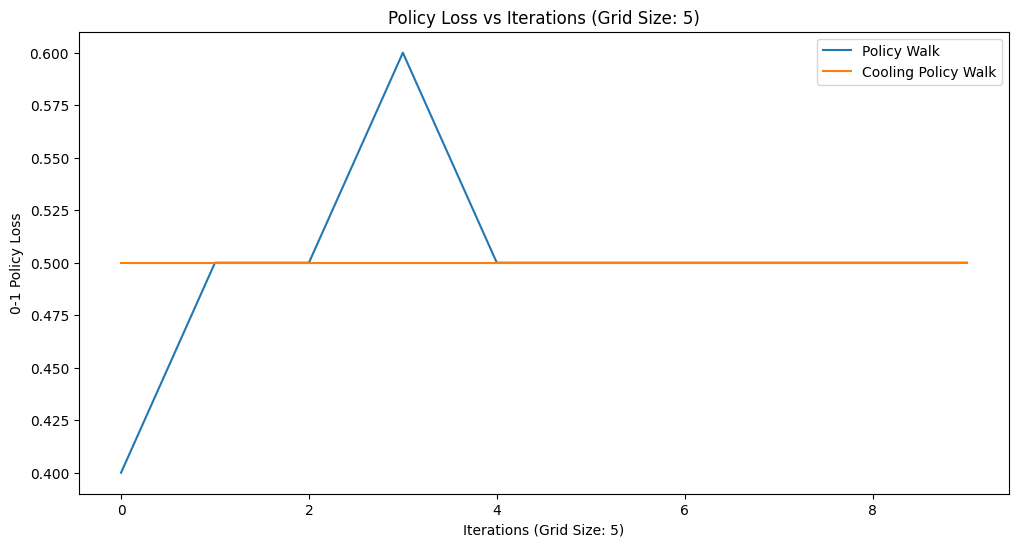

Running experiment with grid size 8 and features {'Treasure': 3, 'Bomb': 6, 'Mud': 9, 'Water': 6, 'Mountain': 3}
Optimal policy computed, now simulating tutor interactions...
Generated Observations: [((0, 0), 'R'), ((0, 0), 'R'), ((0, 1), 'U'), ((0, 1), 'U'), ((0, 1), 'U'), ((0, 1), 'U'), ((0, 1), 'U'), ((0, 1), 'U'), ((0, 1), 'U'), ((0, 1), 'U')]
Best reward from PolicyWalk: [[-0.25091976  0.90142861  0.46398788  0.19731697 -0.68796272 -0.68801096
  -0.88383278  0.73235229]
 [ 0.20223002  0.41614516 -0.95883101  0.9398197   0.66488528 -0.57532178
  -0.63635007 -0.63319098]
 [-0.39151551  0.04951286 -0.13610996 -0.41754172  0.22370579 -0.72101228
  -0.4157107  -0.26727631]
 [-0.08786003  0.57035192 -0.60065244  0.02846888  0.18482914 -0.90709917
   0.2150897  -0.65895175]
 [-0.86989681  0.89777107  0.93126407  0.6167947  -0.39077246 -0.80465577
   0.36846605 -0.11969501]
 [-0.75592353 -0.00964618 -0.93122296  0.8186408  -0.48244004  0.32504457
  -0.37657785  0.04013604]
 [ 0.09342056 -

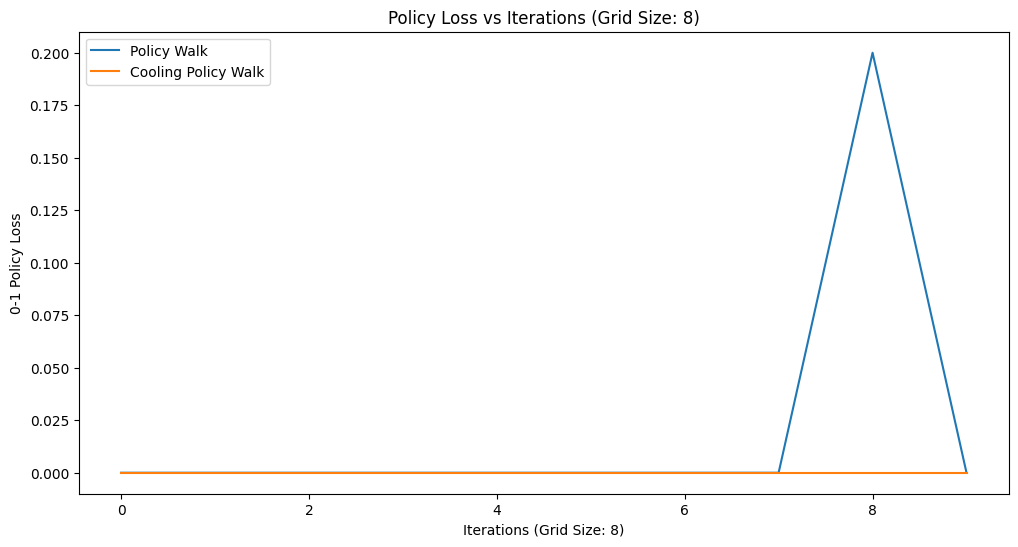

Running experiment with grid size 10 and features {'Treasure': 5, 'Bomb': 10, 'Mud': 15, 'Water': 10, 'Mountain': 5}
Optimal policy computed, now simulating tutor interactions...
Generated Observations: [((0, 0), 'R'), ((0, 1), 'R'), ((1, 1), 'R'), ((1, 2), 'U'), ((1, 1), 'R'), ((1, 2), 'U'), ((0, 2), 'R'), ((0, 3), 'R'), ((0, 4), 'R'), ((0, 5), 'R')]
Best reward from PolicyWalk: [[-0.25091976  0.90142861  0.46398788  0.19731697 -0.68796272 -0.68801096
  -0.88383278  0.73235229  0.20223002  0.41614516]
 [-0.95883101  0.9398197   0.66488528 -0.57532178 -0.63635007 -0.63319098
  -0.39151551  0.04951286 -0.13610996 -0.41754172]
 [ 0.22370579 -0.72101228 -0.4157107  -0.26727631 -0.08786003  0.57035192
  -0.60065244  0.02846888  0.18482914 -0.90709917]
 [ 0.2150897  -0.65895175 -0.86989681  0.89777107  0.93126407  0.6167947
  -0.39077246 -0.80465577  0.36846605 -0.11969501]
 [-0.75592353 -0.00964618 -0.93122296  0.8186408  -0.48244004  0.32504457
  -0.37657785  0.04013604  0.09342056 -0.630

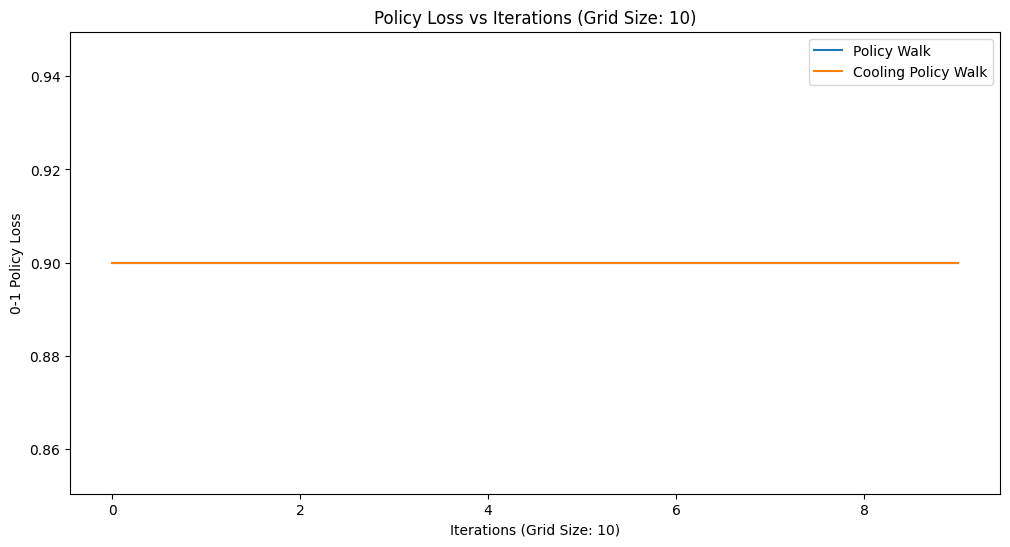

Experiments completed and results plotted.


In [36]:
def evaluate_policy_loss(observations, reward_function, mdp):
    policy_iteration = PolicyIteration(mdp, reward_function)
    _, optimal_policy = policy_iteration.solve()
    loss = 0
    for state, action in observations:
        if optimal_policy[state] != action:
            loss += 1
    return loss/len(observations)

def plot_performance(performance, performance_cooling, param_values, param_name):
    plt.figure(figsize=(12,6))
    plt.plot(param_values, performance, label='Policy Walk')
    plt.plot(param_values, performance_cooling, label='Cooling Policy Walk')
    plt.xlabel(param_name)
    plt.ylabel('0-1 Policy Loss')
    plt.title(f'Policy Loss vs {param_name}')
    plt.legend()
    plt.show()

def run_experiments(grid_size, feature_counts, num_iterations, step_size, initial_state, cooling_rate):
    print(f"Running experiment with grid size {grid_size} and features {feature_counts}")
    mdp = RandomPartialMDP(rows=grid_size, columns=grid_size, feature_counts=feature_counts)

    # Use policy iteration to find the optimal policy for the initial reward function
    reward_function = mdp.get_rewards()
    policy_iteration = PolicyIteration(mdp, reward_function)
    _, optimal_policy = policy_iteration.solve()

    print("Optimal policy computed, now simulating tutor interactions...")
    # Generate observations using the imperfect tutor simulation
    imperfect_tutor = ImperfectTutorSimulation(mdp, reward_function, optimal_policy)
    initial_state = (0, 0)
    num_timesteps = 10
    observations = imperfect_tutor.simulate(initial_state, num_timesteps)

    # Debugging: Print observations to verify structure
    print("Generated Observations:", observations)

    if not observations:
        raise ValueError("No observations generated. Check the generate_observations method.")

    # Initialize the priors and posterior calculator
    gaussian_prior = GaussianPrior(sigma=1)
    q_calculator = QValueCalculator(mdp)
    likelihood_calculator = LikelihoodCalculator(mdp, alpha=1)
    posterior_calculator = PosteriorCalculator(gaussian_prior, q_calculator, likelihood_calculator)

    # Run the PolicyWalk algorithm
    policy_walk = PolicyWalk(mdp, gaussian_prior, posterior_calculator, 0.1, 1000)
    best_reward = policy_walk.walk()
    print("Best reward from PolicyWalk:", best_reward)

    # Run the CoolingPolicyWalk algorithm
    cooling_policy_walk = CoolingPolicyWalk(mdp, gaussian_prior, posterior_calculator, observations, step_size=0.1, iterations=1000, initial_temp=1.0, cooling_rate=0.95)
    best_reward_cooling = cooling_policy_walk.walk()
    print("Best reward from CoolingPolicyWalk:", best_reward_cooling)

    # Evaluate the performance
    performance = [evaluate_policy_loss(observations, policy_walk.neighbor_reward_vector(best_reward), mdp) for _ in range(num_iterations)]
    performance_cooling = [evaluate_policy_loss(observations, cooling_policy_walk.neighbor_reward_vector(best_reward_cooling), mdp) for _ in range(num_iterations)]

    return performance, performance_cooling


# Experiments
grid_sizes = [5, 8, 10]
feature_counts_list = [
    {'Treasure': 1, 'Bomb': 2, 'Mud': 3, 'Water': 2, 'Mountain': 1},
    {'Treasure': 3, 'Bomb': 6, 'Mud': 9, 'Water': 6, 'Mountain': 3},
    {'Treasure': 5, 'Bomb': 10, 'Mud': 15, 'Water': 10, 'Mountain': 5}
]
num_iterations = 10
step_size = 0.1
initial_temp = 1.0
cooling_rate = 0.95

# Run experiments for different grid sizes and feature counts
for grid_size, feature_counts in zip(grid_sizes, feature_counts_list):
    performance, performance_cooling = run_experiments(grid_size, feature_counts, num_iterations, step_size, initial_temp, cooling_rate)
    plot_performance(performance, performance_cooling, list(range(num_iterations)), f'Iterations (Grid Size: {grid_size})')

print("Experiments completed and results plotted.")

### Grid Size 5

#### Generated observations
```plaintext
[((0, 0), 'R'), ((0, 1), 'R'), ((0, 2), 'R'), ((0, 3), 'R'), ((1, 3), 'R'), ((0, 3), 'R'), ((0, 4), 'D'), ((1, 4), 'D'), ((2, 4), 'R'), ((2, 4), 'R')]
```
When we take a look at the first plot, we can see that the policy walk algorithm shows fluctuations in policy loss, indicating variability in performance improvement. At the same time, the cooling policy walk algorithm maintains a consistent policy loss but does not improve, staying at a higher loss level compared to the best instances of PolicyWalk.

### Grid Size 8

#### Generated observations (we generated the same observations)
```plaintext
[((0, 0), 'R'), ((0, 1), 'R'), ((0, 2), 'R'), ((0, 3), 'R'), ((1, 3), 'R'), ((0, 3), 'R'), ((0, 4), 'D'), ((1, 4), 'D'), ((2, 4), 'R'), ((2, 4), 'R')]
```

When looking at the second plot, we notice that the policy walk algorithm shows a significant improvement in policy loss at one point, dropping to zero before rising again.
The cooling policy walk algorithm is still maintaining a consistent policy loss but does not improve, staying at a higher loss level compared to the best instances of PolicyWalk.


### Grid Size 10

#### Generated observations
```plaintext
[((0, 0), 'R'), ((0, 1), 'U'), ((0, 1), 'U'), ((0, 1), 'U'), ((0, 1), 'U'), ((0, 1), 'U'), ((0, 1), 'U'), ((0, 1), 'U'), ((0, 1), 'U'), ((0, 1), 'U')]
```

Finally, both policy walk and cooling policy walk maintain a consistent policy loss with little to no fluctuation (even though we cannot see the blue curve representing the policy walk).
The cooling policy walk shows slightly more stability in maintaining a consistent policy loss level.